<a href="https://colab.research.google.com/github/Gibsdevops/NLP_with_tensorflow/blob/main/nlp_subword.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
#get the dataset
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P \
    -O /tmp/sentiment.csv

--2025-06-11 09:29:44--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 74.125.20.101, 74.125.20.138, 74.125.20.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.20.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P [following]
--2025-06-11 09:29:44--  https://drive.usercontent.google.com/download?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.107.132, 2607:f8b0:400e:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.107.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127831 (125K) [application/octet-stream]
Saving to: ‘/tmp/sentiment.csv’

/tmp/sentiment.csv  100%[===================>] 124.83K  --.-KB/s    in 0.001s  

2025-06-11 09:29:47 (106 MB/s)

In [4]:
import pandas as pd

dataset = pd.read_csv('/tmp/sentiment.csv')

sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

In [6]:
import tensorflow_datasets as tfds

vocab_size = 1000

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length=5)

In [7]:
# Check that the tokenizer works appropriately
num = 5
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)
# Separately print out each subword, decoded
for i in encoded:
  print(tokenizer.decode([i]))

I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]
I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


Replace sentence data with encoded subwords
Now, we'll re-create the dataset to be used for training by actually encoding each of the individual sentences. This is equivalent to text_to_sequences with the Tokenizer we used in earlier exercises.



In [8]:
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

In [9]:
print(sentences[num])

[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


Final pre-processing
Before training, we still need to pad the sequences, as well as split into training and test sets.

In [10]:
import numpy as np

max_length = 50
trunc_type='post'
padding_type='post'

# Pad all sentences
sentences_padded = pad_sequences(sentences, maxlen=max_length,
                                 padding=padding_type, truncating=trunc_type)

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sentences = sentences_padded[0:training_size]
testing_sentences = sentences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [12]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
num_epochs = 30
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(training_sentences, training_labels_final, epochs=num_epochs,
                    validation_data=(testing_sentences, testing_labels_final))

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.4973 - loss: 0.6942 - val_accuracy: 0.5890 - val_loss: 0.6969
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4700 - loss: 0.6888 - val_accuracy: 0.5890 - val_loss: 0.7009
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4946 - loss: 0.6878 - val_accuracy: 0.5890 - val_loss: 0.7005
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4848 - loss: 0.6828 - val_accuracy: 0.5890 - val_loss: 0.7016
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4785 - loss: 0.6744 - val_accuracy: 0.5890 - val_loss: 0.6797
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5050 - loss: 0.6627 - val_accuracy: 0.5890 - val_loss: 0.6737
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4834 - loss: 0.6440 - val_accuracy: 0.6591 - val_loss: 0.6686
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5760 - loss: 0.6204 - val_accuracy: 0.6541 - val_loss

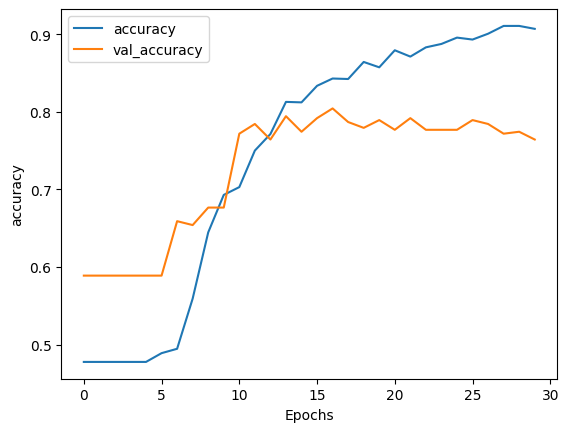

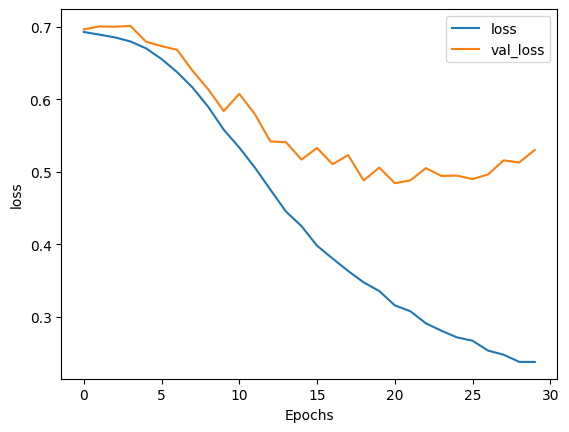

In [14]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [15]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(1000, 16)


In [16]:
import io

# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(0, vocab_size - 1):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [17]:
# Download the files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>